In [92]:
# from  google.colab import drive

# drive.mount('/content/drive')
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [18]:
# print(len(padded_sentences))

In [20]:
# from kaggle.api.kaggle_api_extended import KaggleApi
# api = KaggleApi()
# api.authenticate()  # Run this if you haven't authenticated with Kaggle API yet
# api.dataset_download_file('Mavis/your-dataset-name', file_name=model_sentimentanalysis_final.pth', path='/kaggle/working/')


In [21]:
### elmo from scratch

In [22]:
# import modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
import string
nltk.download('punkt')  # Make sure you have the punkt tokenizer data downloaded
import csv
import re
import random
import copy
%matplotlib inline

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
class_index_train = []
description_train = []
class_index_train_elmo = []
description_train_elmo = []


csv_file_path = '/kaggle/input/nlp-a4-data/data/train.csv'
with open(csv_file_path, 'r', newline='', encoding='utf-8') as csv_file:
    csv_reader = csv.reader(csv_file)
    
    # Skip the header row if it exists
    next(csv_reader, None)
    
    # Iterate through the rows and extract data
    for row in csv_reader:
        #remove trailing or leading spaces
        class_index = row[0].strip() 
        description = row[1].strip()  
        
        # Append the data to their respective lists
        class_index_train.append(class_index)
        description_train.append(description)
        class_index_train_elmo.append(class_index)
        description_train_elmo.append(description)





In [24]:


# Initialize empty lists to store the data
class_index_test = []
description_test = []


# Specify the path to your CSV file
csv_file_path = '/kaggle/input/nlp-a4-data/data/test.csv'

# Open and read the CSV file
with open(csv_file_path, 'r', newline='', encoding='utf-8') as csv_file:
    csv_reader = csv.reader(csv_file)
    
    # Skip the header row if it exists
    next(csv_reader, None)
    
    # Iterate through the rows and extract data
    for row in csv_reader:
        class_index = row[0].strip()  # Extract and strip the Class Index
        description = row[1].strip()  # Extract and strip the Description
        
        # Append the data to their respective lists
        class_index_test.append(class_index)
        description_test.append(description)




In [25]:
text = ' '.join(description_train_elmo)
test_text = ' '.join(description_test)


In [26]:
print(type(test_text))
print(type(text))

<class 'str'>
<class 'str'>


In [27]:
# words = word_tokenize(text)


In [28]:
words = re.split(r'(?<!\\)\\', text)
train_words = [nltk.word_tokenize(sentence) for sentence in words]

wordss = re.split(r'(?<!\\)\\', test_text)
test_words = [nltk.word_tokenize(sentence) for sentence in wordss]



In [29]:
# print((test_word[1:2]))
print((train_words[1:2]))

[['band', 'of', 'ultra-cynics', ',', 'are', 'seeing', 'green', 'again', '.', 'Reuters', '-', 'Private', 'investment', 'firm', 'Carlyle', 'Group', ',']]


In [31]:
# max_length = max(test_words, key=len)
# print(len(max_length))

In [32]:
pad_token = '<pad>'
desired_length = 50

# Iterate through each sentence and pad or truncate it
padded_list = []
for sentence in test_words:
    if len(sentence) >= desired_length:
        padded_sentence = sentence[:desired_length]
    else:
        num_padding = desired_length - len(sentence)
        padded_sentence = sentence + ([pad_token]* num_padding)
    padded_list.append(padded_sentence)


In [33]:
## creating the vocabulary
words = [word for sublist in train_words for word in sublist]
for word in words:
    word.lower()
words = [word for word in words if word not in string.punctuation]
words.append('unk')
vocab=set(words)
# print(len(vocab))

In [56]:
from gensim.models import KeyedVectors
import numpy as np
import random

# Load the pre-trained Word2Vec model
word2vec_model = KeyedVectors.load_word2vec_format('/kaggle/input/word2vec/GoogleNews-vectors-negative300.bin', binary=True)

# Assuming train_vocabulary is a list of words
embedding_dim=300
embedding_matrix=np.zeros((len(vocab),embedding_dim))

for i,word in enumerate(vocab):
    if word in word2vec_model:
        embedding = word2vec_model[word]
    else:
        # Handle missing words by assigning zeros
        embedding = np.random.randn(embedding_dim).astype(np.float32)
    embedding_matrix[i] = embedding


In [35]:
print(type(embedding_matrix))

<class 'numpy.ndarray'>


In [36]:
print(len(embedding_matrix))

93747


In [37]:
word_to_index = {word: index for index, word in enumerate(vocab)}
index_to_word = {index: word for index, word in enumerate(vocab)}

# Convert tokenized words to their indices with respect to the embedding layer
word_indices = [word_to_index[word] if word in vocab else word_to_index['<UNK>'] for word in words]


In [38]:
padded_lists = []
for sentence in padded_list:
    padded_lists.append([word_to_index[word] if word in vocab else word_to_index['unk'] for word in sentence])


In [39]:
n = 7  # Define the n-gram size (6 + 1)

# Initialize a list to store input and target pairs
input_target_pairs = []

# Create input and target pairs
for i in range(len(word_indices) - n + 1):
    input_indices = word_indices[i:i+6]
    target_index = word_indices[i+6]
    input_target_pairs.append((input_indices, target_index))

In [40]:
len(input_target_pairs)

3809460

In [113]:
class ELMO(nn.Module):

    def __init__(self, embedding_matrix, hidden_dim, vocab_size, mode, length ):
        super(ELMO, self).__init__()

        self.hidden_dim = hidden_dim

        # Embedding layer with pretrained embeddings
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)

        # First LSTM layer
        self.lstm1_forward = nn.LSTM(input_size=embedding_matrix.shape[1], hidden_size=hidden_dim, batch_first=True)

        # Second LSTM layer
        self.lstm2_forward = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
        
        self.output_layer_front = nn.Linear(hidden_dim, vocab_size)

        # backward model 
        
        # Output layer with output dimension vocab_size
        
        self.lstm1_back = nn.LSTM(input_size=embedding_matrix.shape[1], hidden_size=hidden_dim, batch_first=True)

        # Second LSTM layer
        self.lstm2_back = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)

        # Output layer with output dimension vocab_size
        self.output_layer_back = nn.Linear(hidden_dim, vocab_size)
        
        
#         ELMO
        weight_value = 0.33
        self.weight1 = nn.Parameter(torch.tensor([weight_value], requires_grad=True))
        self.weight2 = nn.Parameter(torch.tensor([weight_value], requires_grad=True))
        self.weight3 = nn.Parameter(torch.tensor([weight_value], requires_grad=True))
        
        
        ### Learnable Function
        self.output_= nn.Linear(50*600 , 4)

    def forward(self,  input_indices, mode):
        embedded_sequence = self.embedding(input_indices)
        embedded_sequence = embedded_sequence.to(self.lstm1_forward.weight_ih_l0.dtype)

        if mode == 1:
            # Forward prediction
            lstm1_output, _ = self.lstm1_forward(embedded_sequence)
            lstm2_output, _ = self.lstm2_forward(lstm1_output)
            output_probs = self.output_layer_front(lstm2_output[:, -1, :])
        elif mode == 2 :

            lstm1_output, _ = self.lstm1_back(embedded_sequence)
            lstm2_output, _ = self.lstm2_back(lstm1_output)
            output_probs = self.output_layer_back(lstm2_output[:, -1, :])
        elif mode == 3:
            # Freeze parameters of the LSTM layers
            for param in self.lstm1_forward.parameters():
                param.requires_grad = False
            for param in self.lstm2_forward.parameters():
                param.requires_grad = False
            for param in self.lstm1_back.parameters():
                param.requires_grad = False
            for param in self.lstm2_back.parameters():
                param.requires_grad = False
                
            # ELMO prediction
            lstm1_output_f , _ = self.lstm1_forward(embedded_sequence)
            lstm2_output_f , _ = self.lstm2_forward(lstm1_output_f)
            embedded_sequencer= torch.flip(embedded_sequence, [1])
            lstm1_output_r , _= self.lstm1_back(embedded_sequence)
            lstm2_output_r , _ = self.lstm2_back(lstm1_output_r)
            lstm1_output_combined = torch.cat([lstm1_output_f, lstm1_output_r], dim=1)
            lstm2_output_combined = torch.cat([lstm2_output_f, lstm2_output_r], dim=1)
            embed_output_combined = torch.cat([embedded_sequencer,embedded_sequence], dim=1)
            
            
            # Combine LSTM outputs with trainable weights
            weights = torch.softmax(torch.cat([self.weight1, self.weight2, self.weight3]), dim=0)
            weighted_sum = weights[0] * lstm1_output_combined + weights[1] * lstm2_output_combined + weights[2] * embed_output_combined
#             print(len(weighted_sum[0][0]))
#             print("entered")
#             print(weighted_sum.shape)
            weighted_sum = weighted_sum.view(-1)
            output_probs = self.output_(weighted_sum)
        elif mode==4:
             # Freeze parameters of the LSTM layers 
            for param in self.lstm1_forward.parameters():
                param.requires_grad = False
            for param in self.lstm2_forward.parameters():
                param.requires_grad = False
            for param in self.lstm1_back.parameters():
                param.requires_grad = False
            for param in self.lstm2_back.parameters():
                param.requires_grad = False
            
            
            # Freeze parameters of the weights
#             w1=np.random.rand(1)
            self.weight1 = nn.Parameter(torch.tensor([np.random.random()], requires_grad=False))
            self.weight2 = nn.Parameter(torch.tensor([np.random.random()], requires_grad=False))
            self.weight3 = nn.Parameter(torch.tensor([np.random.random()], requires_grad=False))
                
            # ELMO prediction
            lstm1_output_f , _ = self.lstm1_forward(embedded_sequence)
            lstm2_output_f , _ = self.lstm2_forward(lstm1_output_f)
            embedded_sequencer= torch.flip(embedded_sequence, [1])
            lstm1_output_r , _= self.lstm1_back(embedded_sequence)
            lstm2_output_r , _ = self.lstm2_back(lstm1_output_r)
            lstm1_output_combined = torch.cat([lstm1_output_f, lstm1_output_r], dim=1)
            lstm2_output_combined = torch.cat([lstm2_output_f, lstm2_output_r], dim=1)
            embed_output_combined = torch.cat([embedded_sequencer,embedded_sequence], dim=1)
            
            
            # Combine LSTM outputs with trainable weights
            weights = torch.softmax(torch.cat([self.weight1, self.weight2, self.weight3]), dim=0)
            weighted_sum = weights[0] * lstm1_output_combined + weights[1] * lstm2_output_combined + weights[2] * embed_output_combined
#             print(len(weighted_sum[0][0])
#             print(type(weighted_sum))
#             print(weighted_sum.shape)
            weighted_sum = weighted_sum.view(-1)
            output_probs = self.output_(weighted_sum)
        elif mode==5:
             # Freeze parameters of the LSTM layers 
            for param in self.lstm1_forward.parameters():
                param.requires_grad = False
            for param in self.lstm2_forward.parameters():
                param.requires_grad = False
            for param in self.lstm1_back.parameters():
                param.requires_grad = False
            for param in self.lstm2_back.parameters():
                param.requires_grad = False
            
            
            # Freeze parameters of the weights
#             w1=np.random.rand(1)
            self.weight1.requires_grad = False
            self.weight2.requires_grad = False
            self.weight3.requires_grad = False
            # ELMO prediction
            lstm1_output_f , _ = self.lstm1_forward(embedded_sequence)
            lstm2_output_f , _ = self.lstm2_forward(lstm1_output_f)
            embedded_sequencer= torch.flip(embedded_sequence, [1])
            lstm1_output_r , _= self.lstm1_back(embedded_sequence)
            lstm2_output_r , _ = self.lstm2_back(lstm1_output_r)
            lstm1_output_combined = torch.cat([lstm1_output_f, lstm1_output_r], dim=1)
            lstm2_output_combined = torch.cat([lstm2_output_f, lstm2_output_r], dim=1)
            embed_output_combined = torch.cat([embedded_sequencer,embedded_sequence], dim=1)
            
            
            # Combine LSTM outputs with trainable weights
            weights = torch.softmax(torch.cat([self.weight1, self.weight2, self.weight3]), dim=0)
            weighted_sum = weights[0] * lstm1_output_combined + weights[1] * lstm2_output_combined + weights[2] * embed_output_combined
#             print(len(weighted_sum[0][0])
#             print(type(weighted_sum))
#             print(weighted_sum.shape)
            weighted_sum = weighted_sum.view(-1)
            output_probs = self.output_(weighted_sum)


        return output_probs
   

In [114]:
# Define hyperparameters
embedding_dim = 300 # Adjust based on your GloVe embeddings
hidden_dim = 300  # Adjust as needed
vocab_size = len(vocab)  # Size of your vocabulary
learning_rate = 0.01
epochs = 10  # Number of training epochs
sentence_length = desired_length
# Initialize the model
model = ELMO(embedding_matrix=torch.from_numpy(embedding_matrix), hidden_dim=hidden_dim, vocab_size=vocab_size, mode = 1,length = sentence_length)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [58]:
com = []
rev = []
for input_indices, target_index in input_target_pairs:
    com = input_indices + [target_index]  # Convert target_index to a list before concatenation
    rev.append(list(reversed(com)))  # Reverse the list and convert it to a list

In [59]:
input_target_pairs_rev = []

for word in rev:
    input_indices = word[:6]
    target_index = word[-1]
    input_target_pairs_rev.append((input_indices, target_index))

In [60]:
elmo = []

for i in range(len(padded_lists)):
    elmo.append((padded_lists[i], class_index_train[i]))

In [61]:
# Define the percentage of data to use (e.g., 10%)
data_percentage = 0.1

# Calculate the number of samples to use
num_samples = int(len(input_target_pairs) * data_percentage)

# Randomly select a subset of input_target_pairs
random.seed(42)  # Set a random seed for reproducibility
selected_pairs = random.sample(input_target_pairs, num_samples)

In [62]:
len(selected_pairs)

380946

### training the forward model

Epoch 1/10, Train Loss: 0.2322, Valid Loss: 6.9192
Epoch 2/10, Train Loss: 0.2011, Valid Loss: 6.6440
Epoch 3/10, Train Loss: 0.1823, Valid Loss: 6.6158
Epoch 4/10, Train Loss: 0.1644, Valid Loss: 6.6878
Epoch 5/10, Train Loss: 0.1474, Valid Loss: 6.9218
Epoch 6/10, Train Loss: 0.1326, Valid Loss: 7.1902
Epoch 7/10, Train Loss: 0.1201, Valid Loss: 7.4556
Epoch 8/10, Train Loss: 0.1094, Valid Loss: 7.7695
Epoch 9/10, Train Loss: 0.1002, Valid Loss: 8.0188
Epoch 10/10, Train Loss: 0.0922, Valid Loss: 8.2477


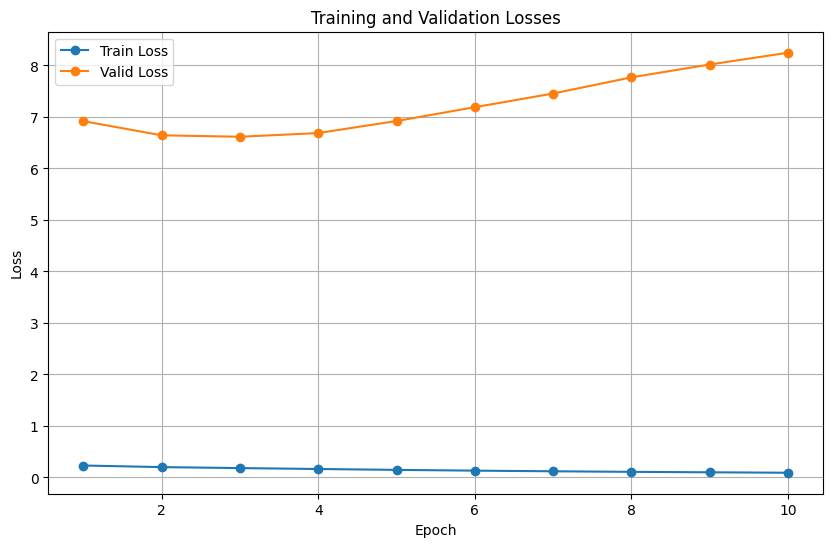

In [63]:
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt  # Import Matplotlib

# Check if a GPU is available, and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move your model and optimizer to the GPU
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

# Split your data into training and validation sets
split_ratio = 0.9  # Adjust as needed
split_idx = int(len(selected_pairs) * split_ratio)
train_pairs = selected_pairs[:split_idx]
valid_pairs = selected_pairs[split_idx:]

# Define your batch size
batch_size = 32

# Lists to store training and validation loss values
train_losses = []
valid_losses = []

# Training loop
epochs = 10  # Adjust the number of epochs as needed
for epoch in range(epochs):
    total_loss = 0

    # Create data loaders for the training and validation sets
    train_inputs, train_targets = zip(*train_pairs)
    train_inputs = torch.tensor(train_inputs, dtype=torch.long).to(device)
    train_targets = torch.tensor(train_targets, dtype=torch.long).to(device)

    train_data = TensorDataset(train_inputs, train_targets)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    valid_inputs, valid_targets = zip(*valid_pairs)
    valid_inputs = torch.tensor(valid_inputs, dtype=torch.long).to(device)
    valid_targets = torch.tensor(valid_targets, dtype=torch.long).to(device)

    valid_data = TensorDataset(valid_inputs, valid_targets)
    valid_loader = DataLoader(valid_data, batch_size=batch_size)

    # Training
    model.train()
    for batch_inputs, batch_targets in train_loader:
        optimizer.zero_grad()

        # Forward pass for forward prediction (mode 1)
        forward_output = model(batch_inputs, mode=1)
        # Calculate the loss for forward prediction
        loss = criterion(forward_output.view(-1, vocab_size), batch_targets.view(-1))

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        valid_loss = 0
        num_batches = 0

        for batch_inputs, batch_targets in valid_loader:
            # Forward pass for forward prediction (mode 1)
            forward_output = model(batch_inputs, mode=1)
            # Calculate the loss for forward prediction
            loss = criterion(forward_output.view(-1, vocab_size), batch_targets.view(-1))

            valid_loss += loss.item()
            num_batches += 1

        avg_valid_loss = valid_loss / num_batches

    # Append the training and validation loss values to the lists
    train_losses.append(total_loss / len(train_pairs))
    valid_losses.append(avg_valid_loss)

    # Update the progress bar description with the current losses
    progress_description = f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}"
    tqdm.write(progress_description)

# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()


### trainging the backward model

In [64]:
# Define the percentage of data to use (e.g., 10%)
data_percentage = 0.1

# Calculate the number of samples to use
num_samples = int(len(input_target_pairs_rev) * data_percentage)

# Randomly select a subset of input_target_pairs
random.seed(42)  # Set a random seed for reproducibility
selected_pairs_rev = random.sample(input_target_pairs_rev, num_samples)

Epoch 1/10, Train Loss: 0.2295, Valid Loss: 6.7520
Epoch 2/10, Train Loss: 0.1959, Valid Loss: 6.5123
Epoch 3/10, Train Loss: 0.1769, Valid Loss: 6.4861
Epoch 4/10, Train Loss: 0.1583, Valid Loss: 6.5847
Epoch 5/10, Train Loss: 0.1409, Valid Loss: 6.8052
Epoch 6/10, Train Loss: 0.1258, Valid Loss: 7.0941
Epoch 7/10, Train Loss: 0.1133, Valid Loss: 7.3447
Epoch 8/10, Train Loss: 0.1028, Valid Loss: 7.6115
Epoch 9/10, Train Loss: 0.0938, Valid Loss: 7.8972
Epoch 10/10, Train Loss: 0.0861, Valid Loss: 8.0721


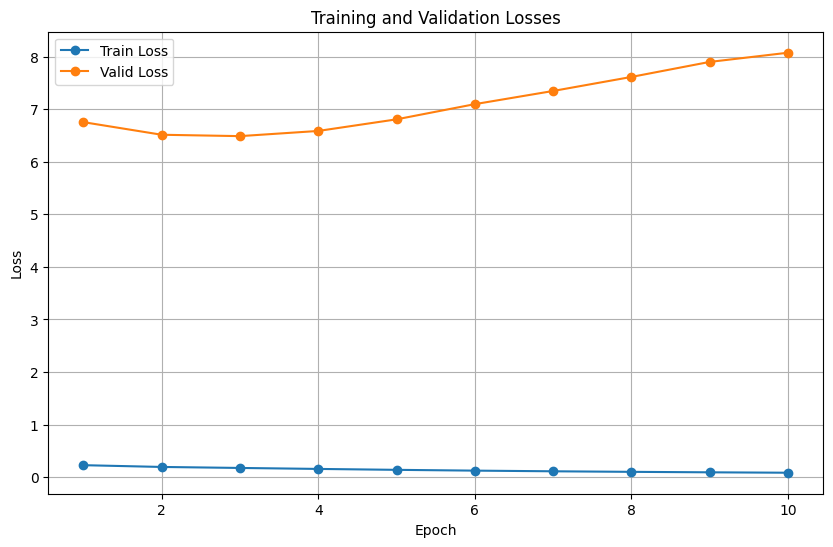

In [65]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt  # Import Matplotlib

# Check if a GPU is available, and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move your model and optimizer to the GPU
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

# Split your data into training and validation sets
split_ratio = 0.9  # Adjust as needed
split_idx = int(len(selected_pairs_rev) * split_ratio)
train_pairs = selected_pairs_rev[:split_idx]
valid_pairs = selected_pairs_rev[split_idx:]

# Define your batch size
batch_size = 32

# Lists to store training and validation loss values
train_losses = []
valid_losses = []

# Training loop
epochs = 10  # Adjust the number of epochs as needed
for epoch in range(epochs):
    total_loss = 0

    # Create data loaders for the training and validation sets
    train_inputs, train_targets = zip(*train_pairs)
    train_inputs = torch.tensor(train_inputs, dtype=torch.long).to(device)
    train_targets = torch.tensor(train_targets, dtype=torch.long).to(device)

    train_data = TensorDataset(train_inputs, train_targets)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    valid_inputs, valid_targets = zip(*valid_pairs)
    valid_inputs = torch.tensor(valid_inputs, dtype=torch.long).to(device)
    valid_targets = torch.tensor(valid_targets, dtype=torch.long).to(device)

    valid_data = TensorDataset(valid_inputs, valid_targets)
    valid_loader = DataLoader(valid_data, batch_size=batch_size)

    # Training
    model.train()
    for batch_inputs, batch_targets in train_loader:
        optimizer.zero_grad()

        # Forward pass for forward prediction (mode 1)
        forward_output = model(batch_inputs, mode=2)
        # Calculate the loss for forward prediction
        loss = criterion(forward_output.view(-1, vocab_size), batch_targets.view(-1))

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        valid_loss = 0
        num_batches = 0

        for batch_inputs, batch_targets in valid_loader:
            # Forward pass for forward prediction (mode 1)
            forward_output = model(batch_inputs, mode=2)
            # Calculate the loss for forward prediction
            loss = criterion(forward_output.view(-1, vocab_size), batch_targets.view(-1))

            valid_loss += loss.item()
            num_batches += 1

        avg_valid_loss = valid_loss / num_batches

    # Append the training and validation loss values to the lists
    train_losses.append(total_loss / len(train_pairs))
    valid_losses.append(avg_valid_loss)

    # Update the progress bar description with the current losses
    progress_description = f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Valid Loss: {avg_valid_loss:.4f}"
    tqdm.write(progress_description)

# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()


### Learning the weights(lamdas)

In [66]:
# Define the percentage of data to use (e.g., 10%)
data_percentage = 1

# Calculate the number of samples to use
num_samples = int(len(elmo) * data_percentage)

# Randomly select a subset of input_target_pairs
random.seed(42)  # Set a random seed for reproducibility
selected_pairs_elmo = random.sample(elmo, num_samples)

Epoch 10/10, Loss: 0.2010, Accuracy: 0.9473, F1 (micro): 0.9473: 100%|██████████| 10/10 [01:13<00:00,  7.38s/it]


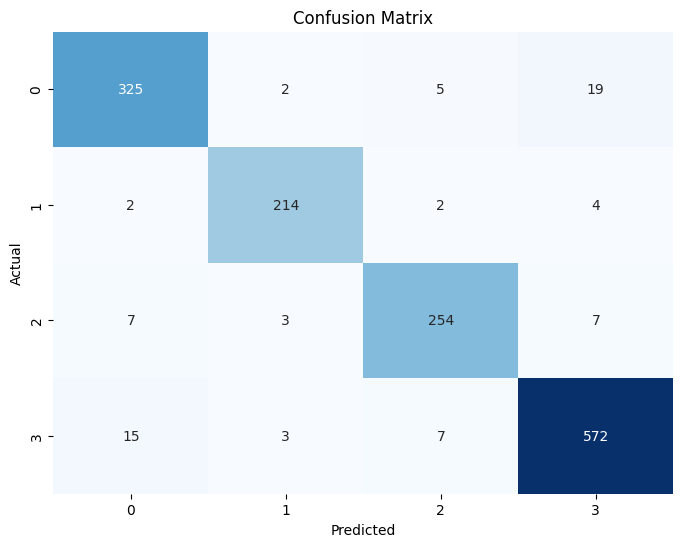

In [107]:
from tqdm import tqdm
import torch
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Check if a GPU is available, and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dimension=300
# Move your model and optimizer to the GPU
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

# Create a progress bar
progress_bar = tqdm(range(epochs), desc="Training")

# Create a data structure to store metrics
metrics_data = []

# Training loop
for epoch in progress_bar:
    total_loss = 0
    all_predicted = []
    all_targets = []

    for input_indices, target_index in selected_pairs_elmo:
        # Move tensors to the GPU
        input_indices = torch.tensor(input_indices, dtype=torch.long).to(device)
        target_index = torch.tensor(int(target_index), dtype=torch.long).to(device)

        optimizer.zero_grad()

        # Forward pass for forward prediction (mode 3)
        forward_output = model(input_indices, mode=3)
        # Calculate the loss for forward prediction
        loss = criterion(forward_output, target_index - 1)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Convert the forward output to class predictions
        _, predicted = torch.max(forward_output, dim=0)

        # Ensure predicted is a Python integer
        predicted = int(predicted)
        all_predicted.append(predicted + 1)  # Append to the list
        all_targets.append(int(target_index.cpu().numpy()))  # Move to CPU and convert to NumPy

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(all_targets, all_predicted)
    f1_micro = f1_score(all_targets, all_predicted, average='micro')

    # Calculate confusion matrix
    confusion = confusion_matrix(all_targets, all_predicted)

    # Store metrics for this epoch
    metrics_data.append({'Epoch': epoch + 1, 'Loss': total_loss / len(selected_pairs_elmo), 'Accuracy': accuracy, 'F1 (micro)': f1_micro})

    # Update the progress bar description
    progress_bar.set_description(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(selected_pairs_elmo):.4f}, Accuracy: {accuracy:.4f}, F1 (micro): {f1_micro:.4f}")

# Close the progress bar
progress_bar.close()


# Create a colored confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Epoch 10/10, Train Loss: 0.0665, Dev Loss: 0.7060, Train Accuracy: 0.9800, Dev Accuracy: 0.8478: 100%|██████████| 10/10 [01:12<00:00,  7.22s/it]


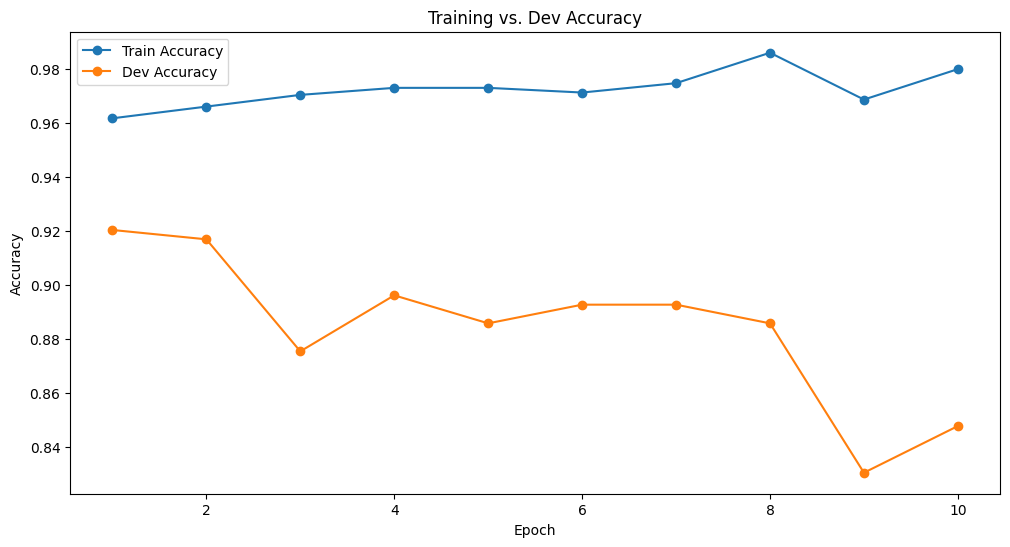

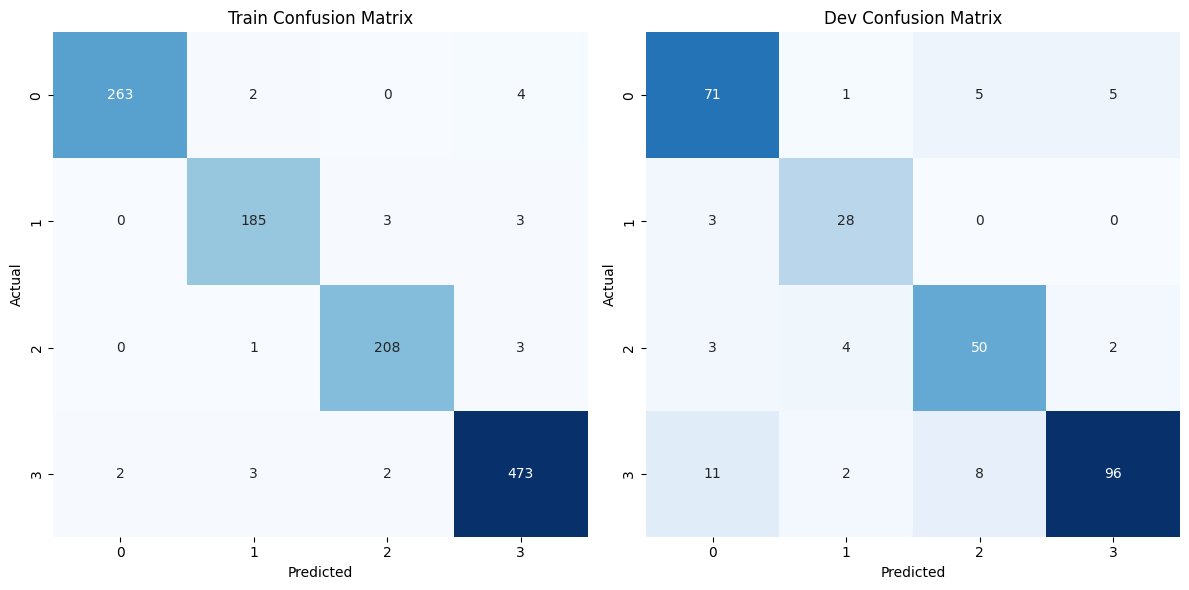

In [108]:
from tqdm import tqdm
import torch
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Check if a GPU is available, and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move your model and optimizer to the GPU
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

# Create a progress bar
progress_bar = tqdm(range(epochs), desc="Training")

# Create a data structure to store metrics for training and dev
train_metrics_data = []
dev_metrics_data = []

# Create a list to store confusion matrices
train_confusion_matrices = []
dev_confusion_matrices = []

# Separate your dataset into training and dev datasets
train_size = int(0.8 * len(selected_pairs_elmo))  # Use 80% for training, 20% for dev
train_pairs = selected_pairs_elmo[:train_size]
dev_pairs = selected_pairs_elmo[train_size:]

# Training loop
for epoch in progress_bar:
    # Training
    model.train()
    total_loss = 0
    all_predicted = []
    all_targets = []

    for input_indices, target_index in train_pairs:
        # Move tensors to the GPU
        input_indices = torch.tensor(input_indices, dtype=torch.long).to(device)
        target_index = torch.tensor(int(target_index), dtype=torch.long).to(device)

        optimizer.zero_grad()

        # Forward pass for forward prediction (mode 3)
        forward_output = model(input_indices, mode=3)
        # Calculate the loss for forward prediction
        loss = criterion(forward_output, target_index - 1)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Convert the forward output to class predictions
        _, predicted = torch.max(forward_output, dim=0)

        # Ensure predicted is a Python integer
        predicted = int(predicted)
        all_predicted.append(predicted + 1)  # Append to the list
        all_targets.append(int(target_index.cpu().numpy()))  # Move to CPU and convert to NumPy

    # Calculate accuracy and F1 score for training
    train_accuracy = accuracy_score(all_targets, all_predicted)
    train_f1_micro = f1_score(all_targets, all_predicted, average='micro')

    # Calculate confusion matrix for training
    train_confusion = confusion_matrix(all_targets, all_predicted)
    train_confusion_matrices.append(train_confusion)

    # Store metrics for training
    train_metrics_data.append({'Epoch': epoch + 1, 'Loss': total_loss / len(train_pairs), 'Accuracy': train_accuracy, 'F1 (micro)': train_f1_micro})

    # Development (Dev)
    model.eval()
    total_loss = 0
    all_predicted = []
    all_targets = []

    for input_indices, target_index in dev_pairs:
        # Move tensors to the GPU
        input_indices = torch.tensor(input_indices, dtype=torch.long).to(device)
        target_index = torch.tensor(int(target_index), dtype=torch.long).to(device)

        # Forward pass for forward prediction (mode 3)
        forward_output = model(input_indices, mode=3)
        # Calculate the loss for forward prediction
        loss = criterion(forward_output, target_index - 1)

        total_loss += loss.item()

        # Convert the forward output to class predictions
        _, predicted = torch.max(forward_output, dim=0)

        # Ensure predicted is a Python integer
        predicted = int(predicted)
        all_predicted.append(predicted + 1)  # Append to the list
        all_targets.append(int(target_index.cpu().numpy()))  # Move to CPU and convert to NumPy

    # Calculate accuracy and F1 score for dev
    dev_accuracy = accuracy_score(all_targets, all_predicted)
    dev_f1_micro = f1_score(all_targets, all_predicted, average='micro')

    # Calculate confusion matrix for dev
    dev_confusion = confusion_matrix(all_targets, all_predicted)
    dev_confusion_matrices.append(dev_confusion)

    # Store metrics for dev
    dev_metrics_data.append({'Epoch': epoch + 1, 'Loss': total_loss / len(dev_pairs), 'Accuracy': dev_accuracy, 'F1 (micro)': dev_f1_micro})

    # Update the progress bar description
    progress_bar.set_description(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_metrics_data[-1]['Loss']:.4f}, Dev Loss: {dev_metrics_data[-1]['Loss']:.4f}, Train Accuracy: {train_accuracy:.4f}, Dev Accuracy: {dev_accuracy:.4f}")

# Close the progress bar
progress_bar.close()

# Create dataframes from metrics data
train_metrics_df = pd.DataFrame(train_metrics_data)
dev_metrics_df = pd.DataFrame(dev_metrics_data)

# Save metrics as CSV
train_metrics_df.to_csv('train_metrics.csv', index=False)
dev_metrics_df.to_csv('dev_metrics.csv', index=False)

# Plot training and dev accuracy over epochs
plt.figure(figsize=(12, 6))
plt.plot(train_metrics_df['Epoch'], train_metrics_df['Accuracy'], label='Train Accuracy', marker='o')
plt.plot(dev_metrics_df['Epoch'], dev_metrics_df['Accuracy'], label='Dev Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Dev Accuracy')
plt.legend()
plt.show()

# Plot confusion matrices
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(train_confusion_matrices[-1], annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Train Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(dev_confusion_matrices[-1], annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Dev Confusion Matrix')

plt.tight_layout()
plt.show()


### Frozen weight parameters

Epoch 10/10, Loss: 0.2919, Accuracy: 0.9008, F1 (micro): 0.9008: 100%|██████████| 10/10 [01:13<00:00,  7.33s/it]


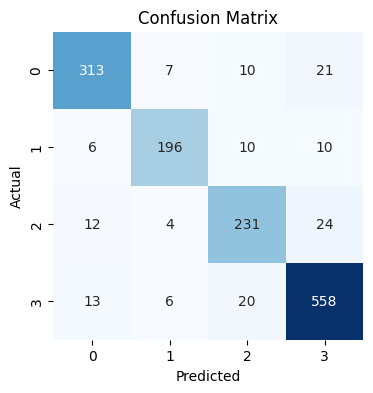

In [115]:
from tqdm import tqdm
import torch
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Check if a GPU is available, and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dimension=300
# Move your model and optimizer to the GPU
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

# Create a progress bar
progress_bar = tqdm(range(epochs), desc="Training")

# Create a data structure to store metrics
metrics_data = []

# Training loop
for epoch in progress_bar:
    total_loss = 0
    all_predicted = []
    all_targets = []

    for input_indices, target_index in selected_pairs_elmo:
        # Move tensors to the GPU
        input_indices = torch.tensor(input_indices, dtype=torch.long).to(device)
        target_index = torch.tensor(int(target_index), dtype=torch.long).to(device)

        optimizer.zero_grad()

     
        forward_output = model(input_indices, mode=4)
        # Calculate the loss for forward prediction
        loss = criterion(forward_output, target_index - 1)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Convert the forward output to class predictions
        _, predicted = torch.max(forward_output, dim=0)

        # Ensure predicted is a Python integer
        predicted = int(predicted)
        all_predicted.append(predicted + 1)  # Append to the list
        all_targets.append(int(target_index.cpu().numpy()))  # Move to CPU and convert to NumPy

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(all_targets, all_predicted)
    f1_micro = f1_score(all_targets, all_predicted, average='micro')

    # Calculate confusion matrix
    confusion = confusion_matrix(all_targets, all_predicted)

    # Store metrics for this epoch
    metrics_data.append({'Epoch': epoch + 1, 'Loss': total_loss / len(selected_pairs_elmo), 'Accuracy': accuracy, 'F1 (micro)': f1_micro})

    # Update the progress bar description
    progress_bar.set_description(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(selected_pairs_elmo):.4f}, Accuracy: {accuracy:.4f}, F1 (micro): {f1_micro:.4f}")

# Close the progress bar
progress_bar.close()

# Create a colored confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Epoch 10/10, Train Loss: 0.1068, Dev Loss: 1.0481, Train Accuracy: 0.9644, Dev Accuracy: 0.7509: 100%|██████████| 10/10 [01:11<00:00,  7.19s/it]


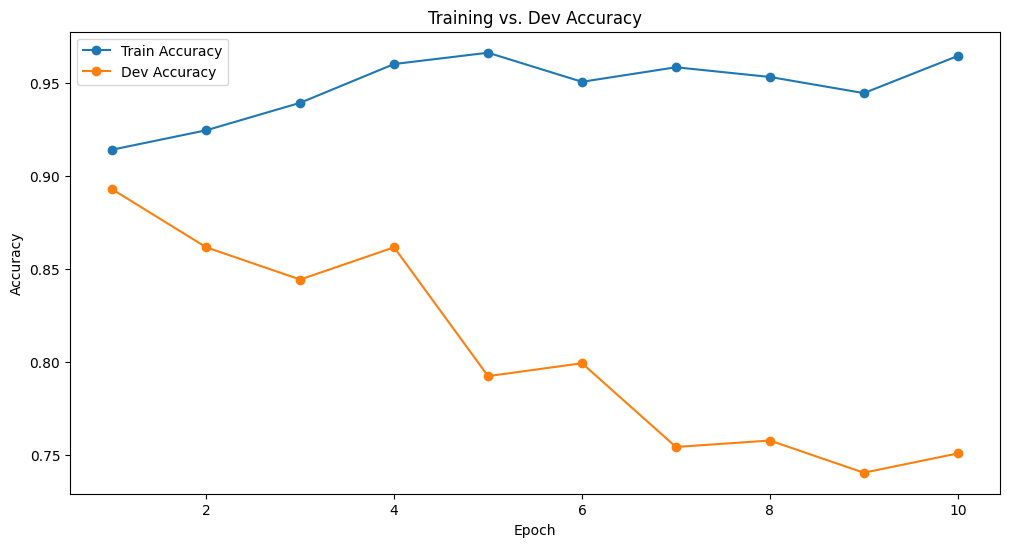

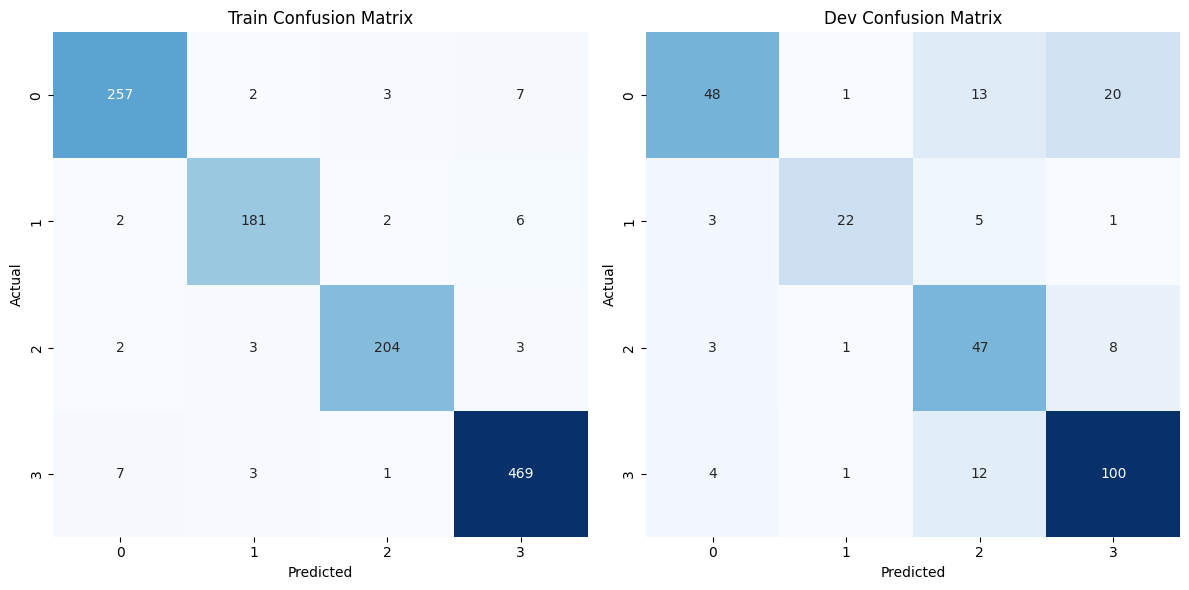

In [117]:
file_path = '/kaggle/working/model.pth'

# Save the model to the specified file
torch.save(model.state_dict(), file_path)

print(f"Model saved to {file_path}")

Model saved to /kaggle/working/model.pth
